In [4]:
import sys
sys.path.append(r"C:\Users\zhaoh\Desktop\CDS")
import pandas as pd
import numpy as np
from src.utils import evaluate
from datasets import Dataset
from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# =====================
# Load data
# =====================
train_metadata_csv = "C:/Users/zhaoh/Desktop/processed_train/metadata.csv"
test_metadata_csv  = "C:/Users/zhaoh/Desktop/processed_test/metadata.csv"

train_df = pd.read_csv(train_metadata_csv)[["utterance", "emotion"]]
test_df  = pd.read_csv(test_metadata_csv)[["utterance", "emotion"]]

# =====================
# Convert to HF Dataset
# =====================
train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)
# =====================
# Label encoding
# =====================
label_list = sorted(train_df["emotion"].unique())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["emotion"]]
    return example

train_labels = train_df["emotion"].map(label2id).values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

train_dataset = train_dataset.map(encode_labels)
test_dataset  = test_dataset.map(encode_labels)

# =====================
# Load tokenizer FIRST
# =====================
model_name = "bhadresh-savani/bert-base-uncased-emotion"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# =====================
# Tokenization
# =====================
def tokenize_function(example):
    return tokenizer(
        example["utterance"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# =====================
# Torch format
# =====================
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

# =====================
# Load model
# =====================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# =====================
# Metrics
# =====================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# =====================
# Training args
# =====================
training_args = TrainingArguments(
    output_dir="C:/Users/zhaoh/Desktop/CDS/text_checkpoint",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)
class WeightedTrainer(Trainer):

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(
            weight=class_weights.to(model.device)
        )

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# =====================
# Trainer
# =====================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics   # <-- keep this
)

# =====================
# Train
# =====================
trainer.train()

# =====================
# Evaluate
# =====================
results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

# =====================
# Confusion Matrix
# =====================
predictions = trainer.predict(test_dataset)

y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

evaluate(y_true,y_pred)

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 780.57it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: bhadresh-savani/bert-base-uncased-emotion
Key                          | Status     |                                                                                       
-----------------------------+------------+---------------------------------------------------------------------------------------
bert.embeddings.position_ids | UNEXPECTED |                                                                                       
classifier.bias              | MISMATCH   | Reinit due to size mismatch - ckpt: torch.Size([6]) vs model:torch.Size([7])          
classifier.weight            | MISMATCH   | Reinit due to size mismatch - ckpt: torch.Size([6, 768]) vs model:torch.Size([7, 768])

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect ident

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.740529,1.470338,0.559387,0.582150
2,1.396162,1.412774,0.536782,0.571562
3,1.159585,1.577146,0.560920,0.580690
4,0.710251,1.704891,0.590805,0.600958
5,0.497361,1.911708,0.587356,0.595331
6,0.414249,1.982632,0.598467,0.605152


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer


Evaluation Results:
{'eval_loss': 1.9826315641403198, 'eval_accuracy': 0.5984674329501916, 'eval_f1': 0.6051522347453633, 'eval_runtime': 13.4268, 'eval_samples_per_second': 194.387, 'eval_steps_per_second': 12.214, 'epoch': 6.0}
Validation Accuracy: 0.5985
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       345
           1       0.34      0.24      0.28        68
           2       0.14      0.24      0.18        50
           3       0.56      0.64      0.60       402
           4       0.80      0.70      0.75      1256
           5       0.33      0.35      0.34       208
           6       0.50      0.61      0.55       281

    accuracy                           0.60      2610
   macro avg       0.44      0.46      0.45      2610
weighted avg       0.62      0.60      0.61      2610

Confusion Matrix:
[[147  14  13  47  48  30  46]
 [ 12  16   3   5  17   6   9]
 [  7   0  12   3  15   7   6]
 [ 35   1 

Train vs Test Class Distribution:
          Train  Test  Train (%)  Test (%)  Total
emotion                                          
anger      1109   345         76        23   1454
disgust     271    68         79        20    339
fear        268    50         84        15    318
joy        1743   402         81        18   2145
neutral    4710  1256         78        21   5966
sadness     683   208         76        23    891
surprise   1205   281         81        18   1486


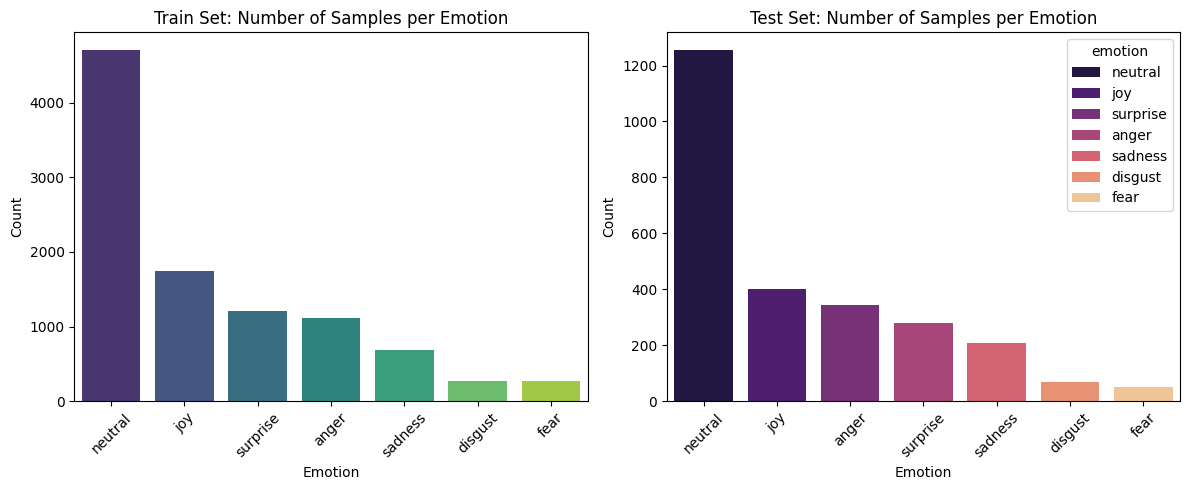

In [11]:
# Number of samples per class
train_df = pd.read_csv(train_metadata_csv)[["emotion"]]
test_df  = pd.read_csv(test_metadata_csv)[["emotion"]]

train_counts = train_df['emotion'].value_counts()
test_counts  = test_df['emotion'].value_counts()

# Combine train and test counts
combined_counts = pd.DataFrame({
    "Train": train_counts,
    "Test": test_counts,
    "Train (%)": (train_counts / (train_counts + test_counts) * 100).round(2),
    "Test (%)": (test_counts / (train_counts + test_counts) * 100).round(2),
    "Total": train_counts+test_counts
}).fillna(0).astype(int)  # fill missing classes with 0

# Optional: sort by Train counts or emotion name
combined_counts = combined_counts.sort_index()

print("Train vs Test Class Distribution:")
print(combined_counts)

# Visualization
plt.figure(figsize=(12,5))

# Train set
plt.subplot(1,2,1)
sns.barplot(x=train_counts.index, y=train_counts.values, palette="viridis",hue=train_counts.index)
plt.title("Train Set: Number of Samples per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Test set
plt.subplot(1,2,2)
sns.barplot(x=test_counts.index, y=test_counts.values, palette="magma",hue=train_counts.index)
plt.title("Test Set: Number of Samples per Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [15]:
# Number of missing or empty texts
train_df = pd.read_csv(train_metadata_csv)
test_df  = pd.read_csv(test_metadata_csv)

missing_train = train_df['utterance'].isnull().sum() + (train_df['utterance'].str.strip() == '').sum()
missing_test  = test_df['utterance'].isnull().sum() + (test_df['utterance'].str.strip() == '').sum()

print(f"Missing/empty texts in train: {missing_train}")
print(f"Missing/empty texts in test: {missing_test}")


Missing/empty texts in train: 0
Missing/empty texts in test: 0


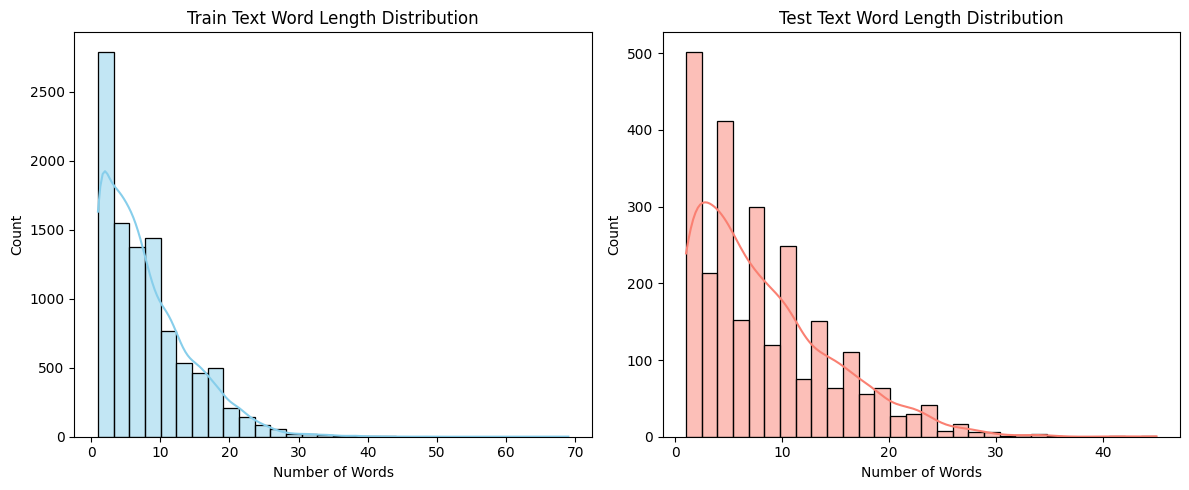

In [17]:
# Text lengths (number of characters or words)
train_df['char_len'] = train_df['utterance'].astype(str).apply(len)
train_df['word_len'] = train_df['utterance'].astype(str).apply(lambda x: len(x.split()))

test_df['char_len'] = test_df['utterance'].astype(str).apply(len)
test_df['word_len'] = test_df['utterance'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(train_df['word_len'], bins=30, kde=True, color='skyblue')
plt.title("Train Text Word Length Distribution")
plt.xlabel("Number of Words")

plt.subplot(1,2,2)
sns.histplot(test_df['word_len'], bins=30, kde=True, color='salmon')
plt.title("Test Text Word Length Distribution")
plt.xlabel("Number of Words")

plt.tight_layout()
plt.show()

In [19]:
def get_unknown_chars(text):
    """Return a set of characters outside standard ASCII (0-127) in a string."""
    return {c for c in str(text) if ord(c) > 127}

# Collect all unknown characters in the train set
train_unknown_chars = set()
train_df['utterance'].dropna().apply(lambda x: train_unknown_chars.update(get_unknown_chars(x)))

# Collect all unknown characters in the test set
test_unknown_chars = set()
test_df['utterance'].dropna().apply(lambda x: test_unknown_chars.update(get_unknown_chars(x)))

print("Unique unknown characters in train set:", train_unknown_chars)
print("Unique unknown characters in test set:", test_unknown_chars)

# Optional: unique characters across both sets
all_unknown_chars = train_unknown_chars.union(test_unknown_chars)
print("Unique unknown characters across all data:", all_unknown_chars)

Unique unknown characters in train set: {'’', '…', '\x93', '\x96', '\xa0', '\x91', '—', '\x92', '\x85', '\x94', 'é', '\x97', 'ó'}
Unique unknown characters in test set: {'’', '\x93', '\xa0', '\x91', '\x92', '\x85', '\x94', 'é', '\x97'}
Unique unknown characters across all data: {'\x96', '—', '\x92', '\x85', 'é', 'ó', '’', '…', '\x93', '\xa0', '\x91', '\x94', '\x97'}


In [22]:
# Function to map each unknown character to one example utterance
def get_example_per_unknown(df, text_col='utterance'):
    char_to_example = {}  # {unknown_char: utterance containing it}
    
    for utterance in df[text_col].dropna():
        for c in utterance:
            if ord(c) > 127 and c not in char_to_example:
                char_to_example[c] = utterance
    return char_to_example

# Train set
train_examples = get_example_per_unknown(train_df)
print("Train set: Example utterance per unknown character:")
for char, example in train_examples.items():
    print(f"'{char}': {example}")

# Test set
test_examples = get_example_per_unknown(test_df)
print("\nTest set: Example utterance per unknown character:")
for char, example in test_examples.items():
    print(f"'{char}': {example}")

Train set: Example utterance per unknown character:
'': also I was the point person on my companys transition from the KL-5 to GR-6 system.
'': This sounds like a hernia. You have toyou-you go to the doctor!
'': No way! Kay look, if I have to go to the doctor for anything its gonna be for this thing sticking out of my stomach!
'': But thats not enough. So Soheres a key to my apartment.
'’': It can’t be me, I’m standing right here.
'': Yeah, well, dont Aww Pheebs, that sucks! me yet.
'': Yeah, well, dont Aww Pheebs, that sucks! me yet.
'…': Of course! Oh Joey, this ring I…it’s beautiful I love it!
' ': Alright you guys, we can’t turn on each other, Okay?   That’s just what she wants.
'': Uh, look buddy, I came with that girl, and I had this plan to kiss her at the new years countdown  Im trying to win her over, so I was wondering if..
'é': Nestlé Toll House?
'—': Tulsa is Italy—Please don’t make me go  there!
'ó': Adiós.

Test set: Example utterance per unknown ch

In [23]:
import re
from unidecode import unidecode

def clean_utterance(text):
    text = str(text)
    # Normalize smart quotes and apostrophes
    text = text.replace('‘','\'').replace('’','\'').replace('','\'').replace('','\'')
    text = text.replace('“','"').replace('”','"').replace('','"').replace('','"')
    
    # Replace ellipsis and special dots
    text = text.replace('…','...').replace('','...')
    
    # Replace dashes
    text = text.replace('—','-').replace('–','-').replace('','-').replace('','-')
    
    # Replace non-breaking space with normal space
    text = text.replace('\xa0',' ').replace(' ',' ')
    
    # Optional: normalize accented characters
    text = unidecode(text)
    
    # Remove any other remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply to train and test
train_df['clean_text'] = train_df['utterance'].apply(clean_utterance)
test_df['clean_text']  = test_df['utterance'].apply(clean_utterance)

In [24]:
# Take the first 10 examples with unknown chars from train and test
train_examples = train_df[train_df['unknown_char_count'] > 0][['utterance']].head(10).copy()
test_examples  = test_df[test_df['unknown_char_count'] > 0][['utterance']].head(10).copy()

# Apply cleaning
train_examples['clean_text'] = train_examples['utterance'].apply(clean_utterance)
test_examples['clean_text']  = test_examples['utterance'].apply(clean_utterance)

# Display results
print("=== Train Examples ===\n")
for i, row in train_examples.iterrows():
    print(f"Original: {row['utterance']}\nCleaned:  {row['clean_text']}\n")

print("\n=== Test Examples ===\n")
for i, row in test_examples.iterrows():
    print(f"Original: {row['utterance']}\nCleaned:  {row['clean_text']}\n")

=== Train Examples ===

Original: also I was the point person on my companys transition from the KL-5 to GR-6 system.
Cleaned:  also I was the point person on my company's transition from the KL-5 to GR-6 system.

Original: You mustve had your hands full.
Cleaned:  You must've had your hands full.

Original: So lets talk a little bit about your duties.
Cleaned:  So let's talk a little bit about your duties.

Original: Now youll be heading a whole division, so youll have a lot of duties.
Cleaned:  Now you'll be heading a whole division, so you'll have a lot of duties.

Original: But therell be perhaps 30 people under you so you can dump a certain amount on them.
Cleaned:  But there'll be perhaps 30 people under you so you can dump a certain amount on them.

Original: No dont I beg of you!
Cleaned:  No don't I beg of you!

Original: All right then, well have a definite answer for you on Monday, but I think I can say with some confidence, youll fit in well here.
Cleaned:  All rig

In [27]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

emotions = train_df['emotion'].unique()

# Prepare table
top_words_per_emotion = []

for emo in emotions:
    texts = train_df[train_df['emotion'] == emo]['clean_text'].dropna()
    all_words = ' '.join(texts).split()
    
    # Remove stopwords and very short words
    filtered_words = [w.lower() for w in all_words if w.lower() not in stop_words and len(w) > 2 and w not in string.punctuation]
    
    word_counts = Counter(filtered_words)
    
    # Take top 10 words and format as "word(count)"
    top_10 = [f"{word}({count})" for word, count in word_counts.most_common(10)]
    
    top_words_per_emotion.append([emo] + top_10)

# Create DataFrame
columns = ["Emotion"] + [f"Top_{i+1}" for i in range(10)]
top_words_df = pd.DataFrame(top_words_per_emotion, columns=columns)

# Display table
print(top_words_df)

    Emotion       Top_1       Top_2       Top_3       Top_4        Top_5  \
0   neutral  yeah,(228)  okay,(215)  well,(189)    oh,(171)     get(157)   
1  surprise   what?(72)    god!(58)     oh,(58)  what?!(55)  really?(40)   
2      fear   gonna(21)   can't(16)     get(12)    want(12)      go!(12)   
3   sadness   gonna(46)  sorry.(40)     oh,(39)    like(32)      get(29)   
4       joy     oh,(91)  that's(90)    hey!(72)     get(68)     like(67)   
5   disgust  that's(17)    like(15)   gonna(14)     no,(13)      oh,(12)   
6     anger     get(66)   can't(50)   gonna(49)     no!(43)   that's(42)   

        Top_6        Top_7      Top_8       Top_9      Top_10  
0  gonna(152)  that's(150)   uh,(148)   like(142)  think(134)  
1    wow!(38)     know(36)   like(35)  that's(28)    look(28)  
2    know(11)      no,(10)    uh,(10)   think(10)     oh,(10)  
3   well,(28)   that's(28)  think(27)   can't(26)  really(26)  
4  really(65)    thank(64)   love(62)   okay,(57)   gonna(56)  
5     n

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhaoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


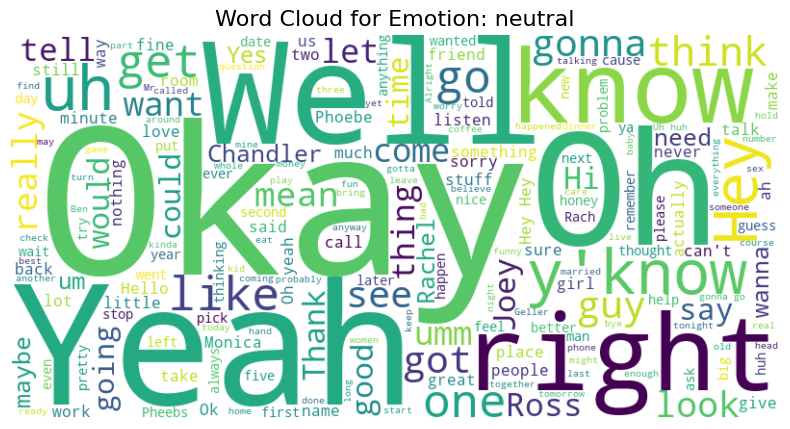

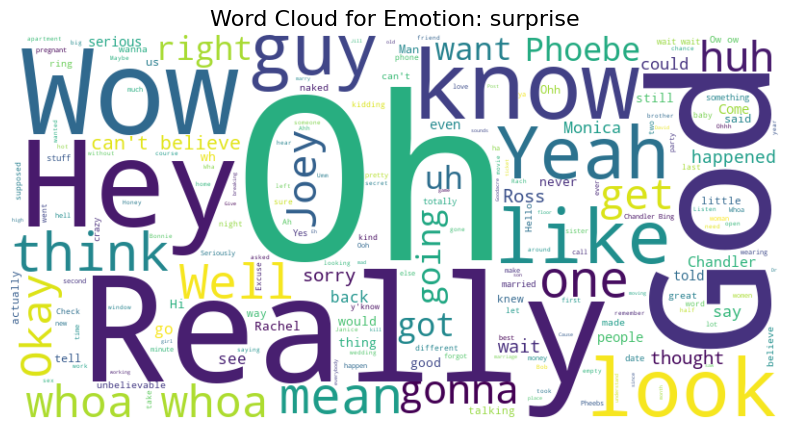

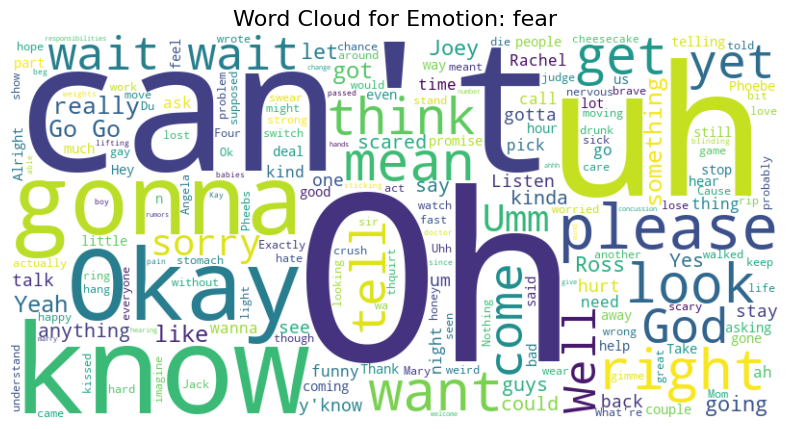

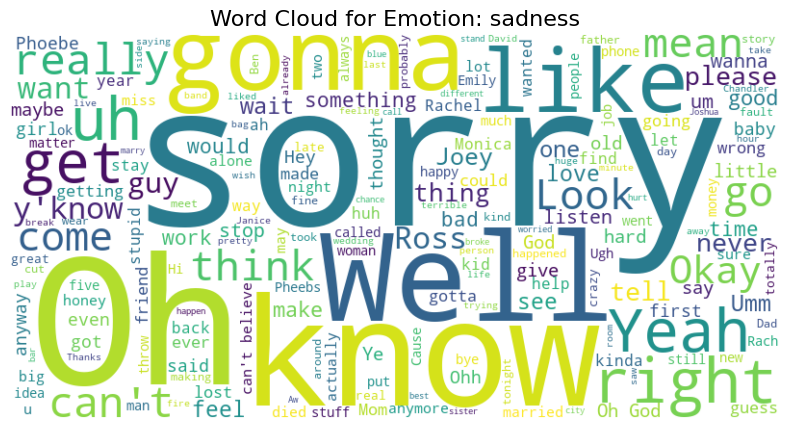

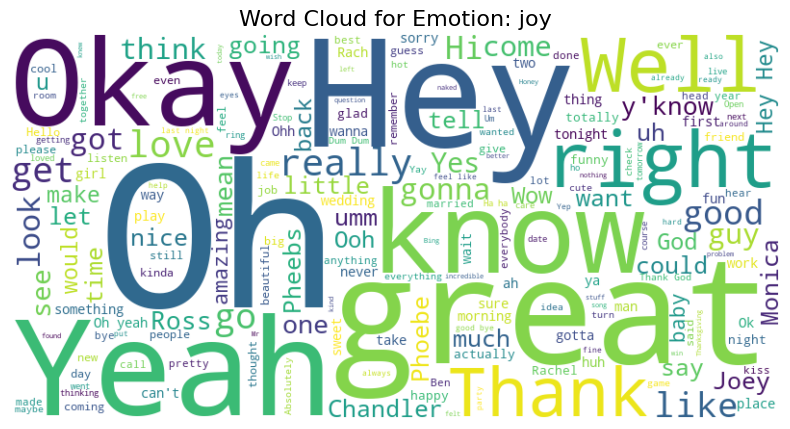

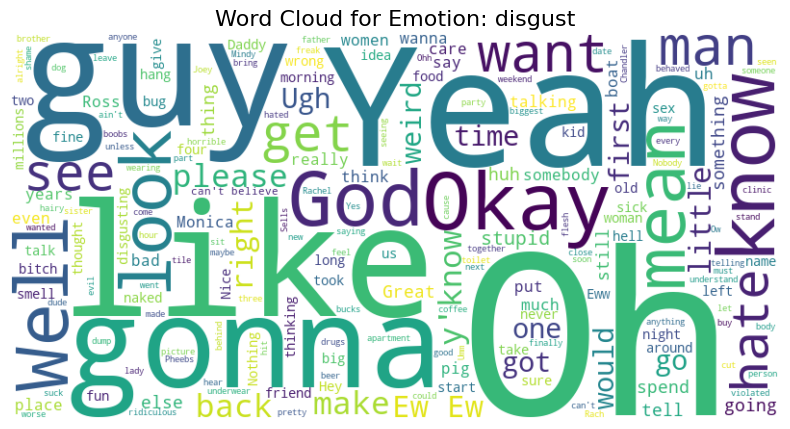

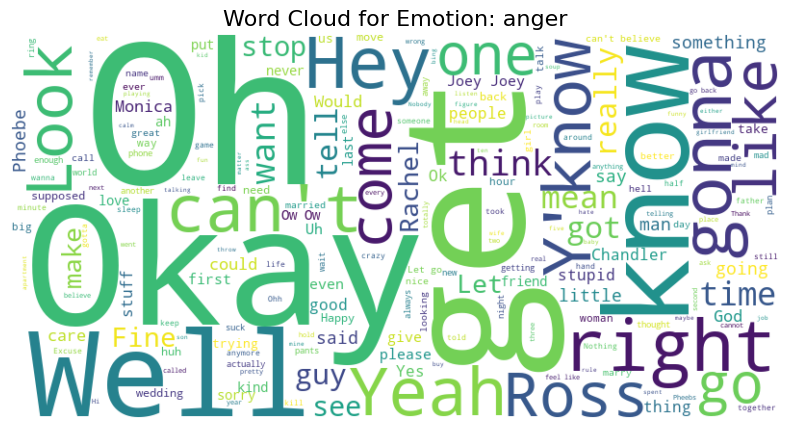

In [29]:
# Word Cloud per emotion class
from wordcloud import WordCloud
emotions = train_df['emotion'].unique()

for emo in emotions:
    texts = train_df[train_df['emotion'] == emo]['clean_text'].dropna()
    all_text = ' '.join(texts)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=stop_words,
        colormap='viridis'
    ).generate(all_text)
    
    # Display
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Emotion: {emo}", fontsize=16)
    plt.show()

In [ ]:
# =====================
# Load data
# =====================

train_df = train_df[["clean_text", "emotion"]]
test_df  = test_df[["clean_text", "emotion"]]

# =====================
# Convert to HF Dataset
# =====================
train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)
# =====================
# Label encoding
# =====================
label_list = sorted(train_df["emotion"].unique())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

def encode_labels(example):
    example["label"] = label2id[example["emotion"]]
    return example

train_labels = train_df["emotion"].map(label2id).values

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)

train_dataset = train_dataset.map(encode_labels)
test_dataset  = test_dataset.map(encode_labels)

# =====================
# Load tokenizer FIRST
# =====================
model_name = "bhadresh-savani/bert-base-uncased-emotion"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# =====================
# Tokenization
# =====================
def tokenize_function(example):
    return tokenizer(
        example["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# =====================
# Torch format
# =====================
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

# =====================
# Load model
# =====================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# =====================
# Metrics
# =====================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# =====================
# Training args
# =====================
training_args = TrainingArguments(
    output_dir="C:/Users/zhaoh/Desktop/CDS/text_checkpoint",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)
class WeightedTrainer(Trainer):

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(
            weight=class_weights.to(model.device)
        )

        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# =====================
# Trainer
# =====================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics   # <-- keep this
)

# =====================
# Train
# =====================
trainer.train()

# =====================
# Evaluate
# =====================
results = trainer.evaluate()
print("\nEvaluation Results:")
print(results)

# =====================
# Confusion Matrix
# =====================
predictions = trainer.predict(test_dataset)

y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

evaluate(y_true,y_pred)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 842.75it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: bhadresh-savani/bert-base-uncased-emotion
Key                          | Status     |                                                                                       
-----------------------------+------------+---------------------------------------------------------------------------------------
bert.embeddings.position_ids | UNEXPECTED |                                                                                       
classifier.bias              | MISMATCH   | Reinit due to size mismatch - ckpt: torch.Size([6]) vs model:torch.Size([7])          
classifier.weight            | MISMATCH   | Reinit due to size mismatch - ckpt: torch.Size([6, 768]) vs model:torch.Size([7, 768])

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect ident

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.711619,1.452836,0.572414,0.587618
2,1.390110,1.409752,0.534100,0.569777
3,1.140135,1.529026,0.562069,0.582923


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
